In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, multivariate_normal

from kdelearn.kde import KDE
from kdelearn.ckde import CKDE
from kdelearn.ckde_tasks import CKDEClassification, CKDEOutliersDetection, CKDEClustering

# Estymator jądrowy w ujęciu warunkowym

Formuła warunkowego estymatora i jej przekształcenia:

$$\hat{f}(X=x|Y=y^*) = \frac{\hat{f}(X=x, Y=y^*)}{\hat{f}(Y=y^*)} \text{,} \quad x \in \mathbb{R}^{n_X} \text{,} \quad y \in \mathbb{R}^{n_Y}$$

$$\hat{f}(X=x|Y=y^*) = \frac{
\sum_{i=1}^m w_{i} \prod_{j=1}^{n_X} \frac{1}{h_j} K \left( \frac{x_{j} - x_{i, j}}{h_j} \right) \prod_{j=1}^{n_Y} \frac{1}{h_{n_X+j}} K \left( \frac{y^*_{j} - y_{i, j}}{h_{n_X+j}} \right)
}{
\sum_{i=1}^m w_{i} \prod_{j=1}^{n_Y} \frac{1}{h_{n_X+j}} K \left( \frac{y^*_{j} - y_{i, j}}{h_{n_X+j}} \right) 
}$$

$$d^*_i = w_i * \prod_{j=1}^{n_Y} K \left( \frac{y^*_{j} - y_{i, j}}{h_{n_X+j}} \right)$$

$$d_i = \frac{d^*_i}{\sum_{i=1}^m d^*_i }$$

$$\hat{f}(X=x|Y=y^*) = \sum_{i=1}^m d_{i} \prod_{j=1}^{n_X} \frac{1}{h_j} K \left( \frac{x_{j} - x_{i, j}}{h_j} \right)$$

* $m$ - liczność zbioru
* $n_X$ - wymiarowość zmiennej objaśniającej
* $n_Y$ - wymiarowość zmiennej warunkowej
* $\mathbf{w}$ - wagi wszystkich elementów zbioru
* $K(x)$ - funkcja jądrowa
* $\mathbf{h}$ - parametr wygładzania

\newpage

Parametry mieszaniny rozkładów Gaussa używanych w dalszych przykładach:

$$
seed=1
$$

$$
m=1000
$$

$$
m_1=0.25m
$$

\begin{equation*}
E_1 =
\left(\begin{array}{c}
-3 \\
0
\end{array}\right)
\end{equation*}

\begin{equation*}
Cov_1 =
\left(\begin{array}{cc}\ 
4 & -1.4\\
-1.4 & 1
\end{array}\right)
\end{equation*}


$$
m_2=0.5m
$$

\begin{equation*}
E_2 =
\left(\begin{array}{c}
2 \\
0
\end{array}\right)
\end{equation*}

\begin{equation*}
Cov_2 =
\left(\begin{array}{cc}\ 
1 & 0.7\\
0.7 & 1
\end{array}\right)
\end{equation*}


$$
m_3=0.15m
$$

\begin{equation*}
E_3 =
\left(\begin{array}{c}
5 \\
0
\end{array}\right)
\end{equation*}

\begin{equation*}
Cov_3 =
\left(\begin{array}{cc}\ 
1 & 0.9\\
0.9 & 1
\end{array}\right)
\end{equation*}


$$
m_4=0.1m
$$

\begin{equation*}
E_4 =
\left(\begin{array}{c}
0 \\
0
\end{array}\right)
\end{equation*}

\begin{equation*}
Cov_4 =
\left(\begin{array}{cc}\ 
25 & 0\\
0 & 4
\end{array}\right)
\end{equation*}

Uwaga: Dane z 4 członu to traktowane są jako szum i nie biorą udziału dalej w przykładzie z klasyfikacją.

\newpage

In [3]:
np.random.seed(1)

# Data
m_train = 1000
n_x, n_y = 1, 1

## class 1
m_train1 = int(0.25 * m_train)
mean1 = [-3, 0]
cov1 = [[4, -1.4],
        [-1.4, 1]]
z_train1 = np.random.multivariate_normal(mean1, cov1, m_train1)
x_train1 = z_train1[:, [0]]
y_train1 = z_train1[:, [1]]
labels_train1 = np.full(m_train1, 1, dtype=np.int32)

## class 2
m_train2 = int(0.5 * m_train)
mean2 = [2, 0]
cov2 = [[1, 0.7],
        [0.7, 1]]
z_train2 = np.random.multivariate_normal(mean2, cov2, m_train2)
x_train2 = z_train2[:, [0]]
y_train2 = z_train2[:, [1]]
labels_train2 = np.full(m_train2, 2, dtype=np.int32)

## class 3
m_train3 = int(0.15 * m_train)
mean3 = [5, 0]
cov3 = [[1, 0.9],
        [0.9, 1]]
z_train3 = np.random.multivariate_normal(mean3, cov3, m_train3)
x_train3 = z_train3[:, [0]]
y_train3 = z_train3[:, [1]]
labels_train3 = np.full(m_train3, 3, dtype=np.int32)

## class 4
m_train4 = int(0.1 * m_train)
mean4 = [0, 0]
cov4 = [[25, 0],
        [0, 4]]
z_train4 = np.random.multivariate_normal(mean4, cov4, m_train4)
x_train4 = z_train4[:, [0]]
y_train4 = z_train4[:, [1]]
labels_train4 = np.full(m_train4, 4, dtype=np.int32)

## 
x_train = np.concatenate((x_train1, x_train2, x_train3, x_train4), axis=0)
y_train = np.concatenate((y_train1, y_train2, y_train3, y_train4), axis=0)
labels_train = np.concatenate((labels_train1, labels_train2, labels_train3, labels_train4))

\newpage

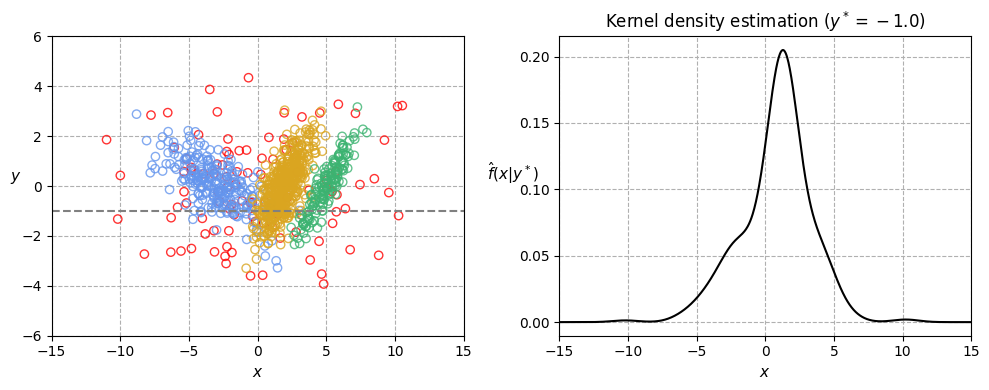

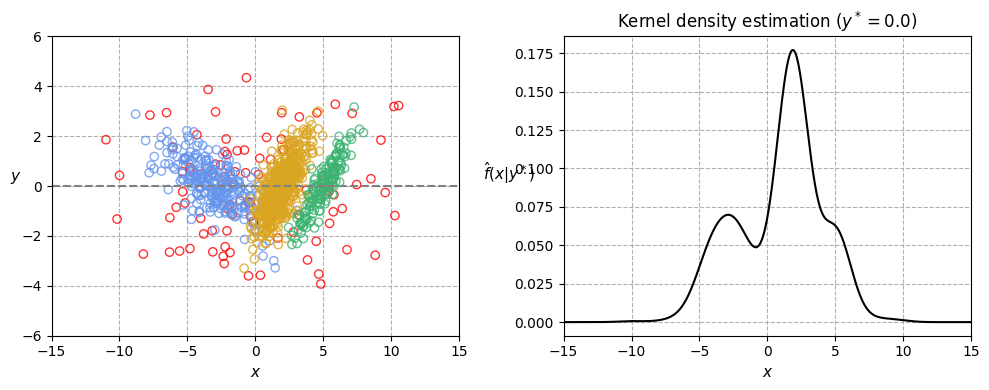

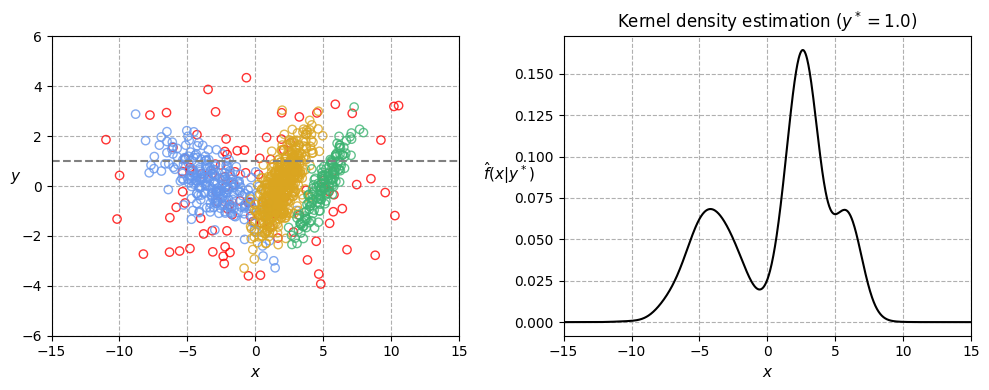

In [4]:
for star in [-1.0, 0.0, 1.0]:
    y_star = np.array([star] * n_y)
    x_grid = np.linspace(-15, 15, 1000)[:, None]

    # CKDE
    ckde = CKDE().fit(x_train, y_train, y_star)
    scores, d = ckde.pdf(x_grid)


    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

    #
    axs[0].scatter(x_train4, y_train4, facecolors="none", edgecolors="red", zorder=2, alpha=0.8)
    axs[0].scatter(x_train1, y_train1, facecolors="none", edgecolors="cornflowerblue", zorder=2, alpha=0.8)
    axs[0].scatter(x_train2, y_train2, facecolors="none", edgecolors="goldenrod", zorder=2, alpha=0.8)
    axs[0].scatter(x_train3, y_train3, facecolors="none", edgecolors="mediumseagreen", zorder=2, alpha=0.8)
    axs[0].axhline(y=y_star[0], color="grey", linestyle='--')

    axs[0].set_xlim(-15, 15)
    axs[0].set_ylim(-6, 6)
    axs[0].set_xlabel("$x$", fontsize=11)
    axs[0].set_ylabel("$y$", fontsize=11, rotation=0)
    axs[0].grid(linestyle="--")

    #
    axs[1].plot(x_grid, scores, c="k")

    axs[1].set_title(f"Kernel density estimation ($y^*={y_star[0]}$)")
    axs[1].set_xlim(-15, 15)
    axs[1].set_xlabel("$x$", fontsize=11)
    axs[1].set_ylabel("$\hat{f}(x|y^*)$", fontsize=11, rotation=0)
    axs[1].grid(linestyle="--")

    #
    plt.tight_layout()
    plt.show()

\newpage

## Porównanie z ujęciem bezwarunkowym

Porównanie trzech estymatorów:

- w ujęciu bez warunkowym bez wag (elementy zbioru są równoważne)
- w ujęciu warunkowym przy $y^*=1.0$
- w ujęciu bezwarunkowym z wagami elementów zbioru. Waga $i$-tego elementu, to odwrotność odległości euklidesowej między $y_i$ a $y^*=1.0$

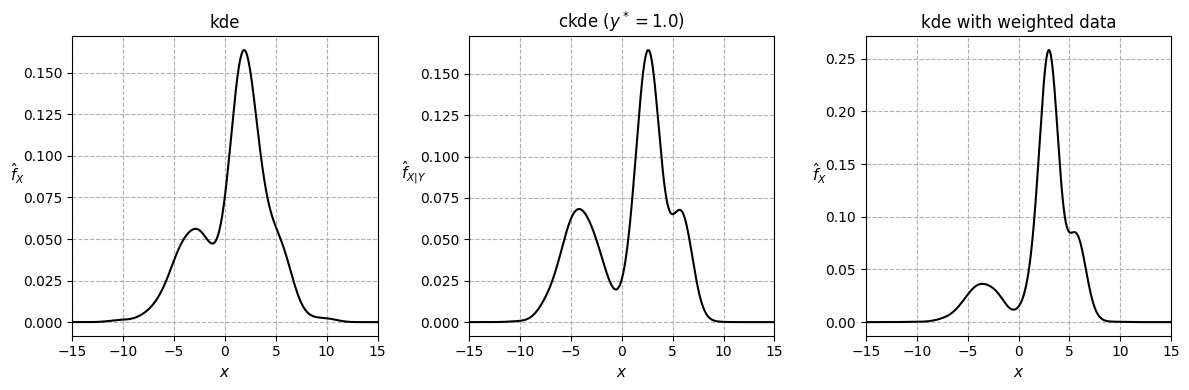

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=100)

#
kde = KDE().fit(x_train)
scores = kde.pdf(x_grid)

axs[0].plot(x_grid, scores, c="k")
axs[0].set_title("kde")
axs[0].set_xlim(-15, 15)
axs[0].set_xlabel("$x$", fontsize=11)
axs[0].set_ylabel("$\hat{f}_X$", fontsize=11, rotation=0)
axs[0].grid(linestyle="--")

#
y_star = np.array([star] * n_y)
ckde = CKDE().fit(x_train, y_train, y_star)
scores, d = ckde.pdf(x_grid)

axs[1].plot(x_grid, scores, c="k")
axs[1].set_title("ckde ($y^*=1.0$)")
axs[1].set_xlim(-15, 15)
axs[1].set_xlabel("$x$", fontsize=11)
axs[1].set_ylabel("$\hat{f}_{X|Y}$", fontsize=11, rotation=0)
axs[1].grid(linestyle="--")

#
weights_train = np.linalg.norm(y_train - y_star, axis=1)
kde = KDE().fit(x_train, 1 / weights_train)
scores = kde.pdf(x_grid)

axs[2].plot(x_grid, scores, c="k")
axs[2].set_title("kde with weighted data")
axs[2].set_xlim(-15, 15)
axs[2].set_xlabel("$x$", fontsize=11)
axs[2].set_ylabel("$\hat{f}_X$", fontsize=11, rotation=0)
axs[2].grid(linestyle="--")

plt.tight_layout()
plt.show()

\newpage

# Klasyfikator

Wzory podobne do ujęcia bezwarunkowego, z tą różnicą, że dochodzi warunek $y^*$.

Przykład: Wykresy gęstości rozkładów poszczególnych klas oraz granica decyzyjna dla powyższych danych przy $y^*=1.0$.

In [6]:
# Data
x_train = np.concatenate((x_train1, x_train2, x_train3), axis=0)
y_train = np.concatenate((y_train1, y_train2, y_train3), axis=0)
labels_train = np.concatenate((labels_train1, labels_train2, labels_train3))

m_train = x_train.shape[0]
x_grid = np.linspace(-15, 15, 1000)[:, None]
y_star = np.array([1.0] * n_y)

classifier = CKDEClassification().fit(x_train, y_train, y_star, labels_train)
scores = classifier.pdfs(x_grid)
labels_pred = classifier.predict(x_grid)

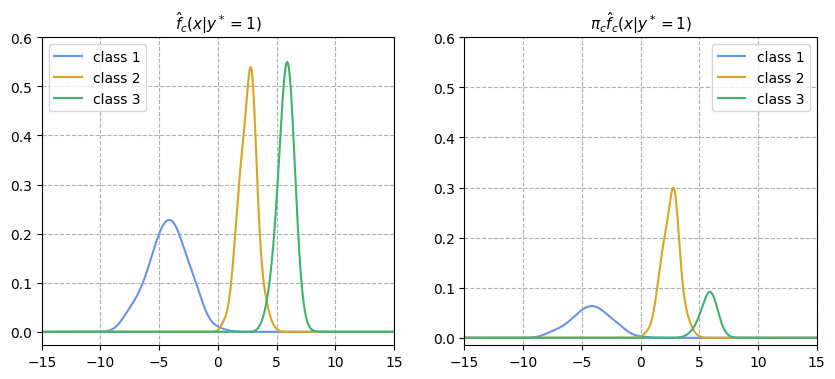

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

axs[0].plot(x_grid, scores[:, 0], c="cornflowerblue", label="class 1")
axs[0].plot(x_grid, scores[:, 1], c="goldenrod", label="class 2")
axs[0].plot(x_grid, scores[:, 2], c="mediumseagreen", label="class 3")
axs[0].set_title("$\hat{f}_c(x|y^*=1)$", fontsize=11)
axs[0].legend(fontsize=10)
axs[0].set_xlim(-15, 15)
axs[0].set_ylim(top=0.6)
axs[0].grid(linestyle="--")

axs[1].plot(x_grid, m_train1 / m_train * scores[:, 0], c="cornflowerblue", label="class 1")
axs[1].plot(x_grid, m_train2 / m_train * scores[:, 1], c="goldenrod", label="class 2")
axs[1].plot(x_grid, m_train3 / m_train * scores[:, 2], c="mediumseagreen", label="class 3")
axs[1].set_title("$\\pi_c \\hat{f}_c(x|y^*=1)$", fontsize=11)
axs[1].legend(fontsize=10)
axs[1].set_xlim(-15, 15)
axs[1].set_ylim(top=0.6)
axs[1].grid(linestyle="--")

plt.show()

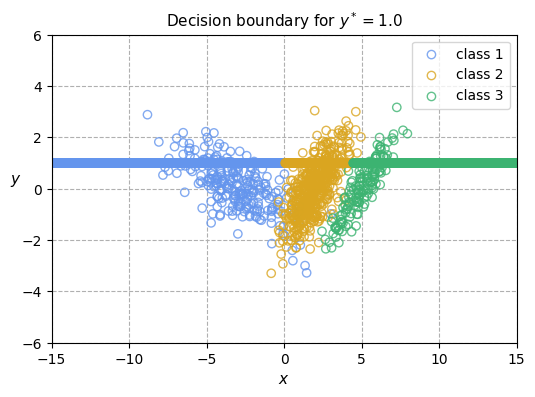

In [8]:
y_grid = np.full(1000, y_star[0])

plt.figure(figsize=(6, 4), dpi=100)

plt.scatter(x_train1, y_train1, facecolors="none", edgecolors="cornflowerblue", zorder=2, alpha=0.8, label="class 1")
plt.scatter(x_train2, y_train2, facecolors="none", edgecolors="goldenrod", zorder=2, alpha=0.8, label="class 2")
plt.scatter(x_train3, y_train3, facecolors="none", edgecolors="mediumseagreen", zorder=2, alpha=0.8, label="class 3")
plt.scatter(x_grid[labels_pred==1], y_grid[labels_pred==1], facecolors="none", edgecolors="cornflowerblue", zorder=2)
plt.scatter(x_grid[labels_pred==2], y_grid[labels_pred==2], facecolors="none", edgecolors="goldenrod", zorder=2)
plt.scatter(x_grid[labels_pred==3], y_grid[labels_pred==3], facecolors="none", edgecolors="mediumseagreen", zorder=2)

plt.title("Decision boundary for $y^*=1.0$", fontsize=11)
plt.legend()
plt.xlim(-15, 15)
plt.ylim(-6, 6)
plt.xlabel("$x$", fontsize=11)
plt.ylabel("$y$", fontsize=11, rotation=0)
plt.grid(linestyle="--")
plt.show()

\newpage

Przetestowanie klasyfikatora na danych treningowych (tych samych, na ktorych zbudowano klasyfikator). W takim przypadku wartości $y_i$ sztucznie zastępowane są przez $y^*=1.0$.

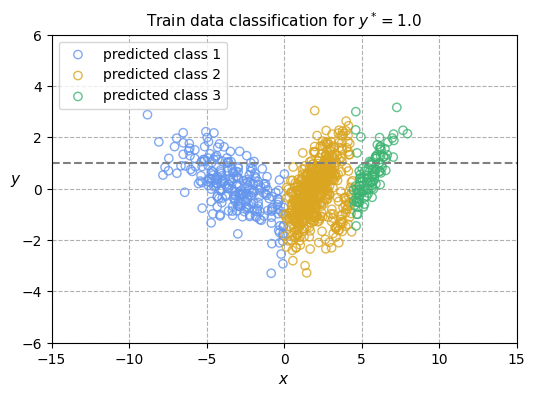

In [9]:
labels_pred = classifier.predict(x_train)

plt.figure(figsize=(6, 4), dpi=100)

plt.scatter(x_train[labels_pred==1], y_train[labels_pred==1], facecolors="none", edgecolors="cornflowerblue", zorder=2, alpha=0.8, label="predicted class 1")
plt.scatter(x_train[labels_pred==2], y_train[labels_pred==2], facecolors="none", edgecolors="goldenrod", zorder=2, alpha=0.8, label="predicted class 2")
plt.scatter(x_train[labels_pred==3], y_train[labels_pred==3], facecolors="none", edgecolors="mediumseagreen", zorder=2, alpha=0.8, label="predicted class 3")
plt.axhline(y=y_star[0], color="grey", linestyle='--')

plt.title("Train data classification for $y^*=1.0$", fontsize=11)
plt.legend()
plt.xlim(-15, 15)
plt.ylim(-6, 6)
plt.xlabel("$x$", fontsize=11)
plt.ylabel("$y$", fontsize=11, rotation=0)
plt.grid(linestyle="--")
plt.show()

Obserwacja: czym bliżej wartości warunkowej $y^*=1.0$, tym większy sens ma taka klasyfikacja.

\newpage

# Wykrywanie elementów odstających

Wzory podobne do ujęcia bezwarunkowego, z tą różnicą, że dochodzi warunek $y^*$.

Dodatkową różnicą jest wzór na estymatora kwantyla $\hat{q}_{r|w^*}$ (tutaj warunkowego) rzędu $r$:

\begin{equation}
\hat{q}_{r|w^*} =
  \begin{cases}
    v_1       & \quad \text{dla } r < d_1\\
    \frac{\sum_{i=1}^{k+1} d_i - r}{d_{k+1}} v_k + \frac{r - \sum_{i=1}^k d_i}{d_{k+1}} v_{k+1}  & \quad \text{dla } r \geq d_1
  \end{cases}.
\end{equation}

(Szczegóły w pracy magisterskiej lub w artykule - wzory delikatnie się różnią ponieważ $d_i$ jest inaczej liczone)

Przykład wykrywania elementów nietypowych dla powyższego zbioru danych przy $y^*=1.0$ oraz $r=1.0$.

In [10]:
# Data
x_train = np.concatenate((x_train1, x_train2, x_train3, x_train4), axis=0)
y_train = np.concatenate((y_train1, y_train2, y_train3, y_train4), axis=0)

m_train = x_train.shape[0]
x_grid = np.linspace(-15, 15, 1000)[:, None]
y_star = np.array([1.0] * n_y)

outliers_detection = CKDEOutliersDetection().fit(x_train, y_train, y_star, r=0.1)
labels_pred = outliers_detection.predict(x_grid)

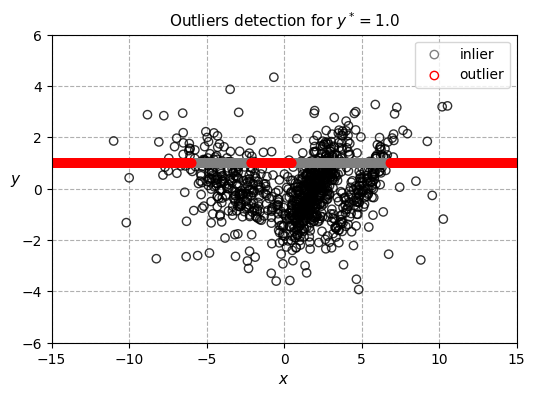

In [11]:
y_grid = np.full(1000, y_star[0])

plt.figure(figsize=(6, 4), dpi=100)

plt.scatter(x_train, y_train, facecolors="none", edgecolors="k", zorder=2, alpha=0.8)
plt.scatter(x_grid[labels_pred==0], y_grid[labels_pred==0], facecolors="none", edgecolors="grey", zorder=2, label="inlier")
plt.scatter(x_grid[labels_pred==1], y_grid[labels_pred==1], facecolors="none", edgecolors="red", zorder=2, label="outlier")

plt.title("Outliers detection for $y^*=1.0$", fontsize=11)
plt.legend()
plt.xlim(-15, 15)
plt.ylim(-6, 6)
plt.xlabel("$x$", fontsize=11)
plt.ylabel("$y$", fontsize=11, rotation=0)
plt.grid(linestyle="--")
plt.show()

\newpage

Przetestowanie detekcji elementów odstających na danych treningowych. W takim przypadku wartości $y_i$ sztucznie zastępowane są przez $y^*=1.0$.

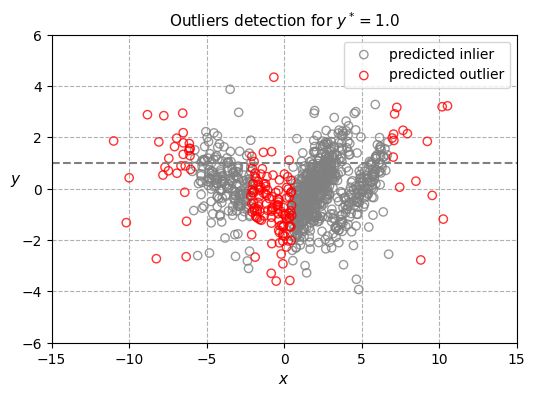

In [12]:
outliers_detection = CKDEOutliersDetection().fit(x_train, y_train, y_star, r=0.1)
labels_pred = outliers_detection.predict(x_train)

y_grid = np.full(1000, y_star[0])

plt.figure(figsize=(6, 4), dpi=100)

plt.scatter(x_train[labels_pred==0], y_train[labels_pred==0], facecolors="none", edgecolors="grey", zorder=2, alpha=0.8, label="predicted inlier")
plt.scatter(x_train[labels_pred==1], y_train[labels_pred==1], facecolors="none", edgecolors="red", zorder=2, alpha=0.8, label="predicted outlier")
plt.axhline(y=y_star[0], color="grey", linestyle='--')

plt.title("Outliers detection for $y^*=1.0$", fontsize=11)
plt.legend()
plt.xlim(-15, 15)
plt.ylim(-6, 6)
plt.xlabel("$x$", fontsize=11)
plt.ylabel("$y$", fontsize=11, rotation=0)
plt.grid(linestyle="--")
plt.show()

Obserwacja: czym bliżej wartości warunkowej $y^*=1.0$, tym większy sens ma taka detekcja.

\newpage

# Klasteryzacja

Wzory podobne do ujęcia bezwarunkowego, z tą różnicą, że dochodzi warunek $y^*$.

Przykład klasteryzacji na powyższych danych:

In [13]:
# Data
x_train = np.concatenate((x_train1, x_train2, x_train3, x_train4), axis=0)
y_train = np.concatenate((y_train1, y_train2, y_train3, y_train4), axis=0)
y_star = np.array([1.0] * n_y)

clustering = CKDEClustering().fit(x_train, y_train, y_star)
labels_pred = clustering.predict("mean_shift")

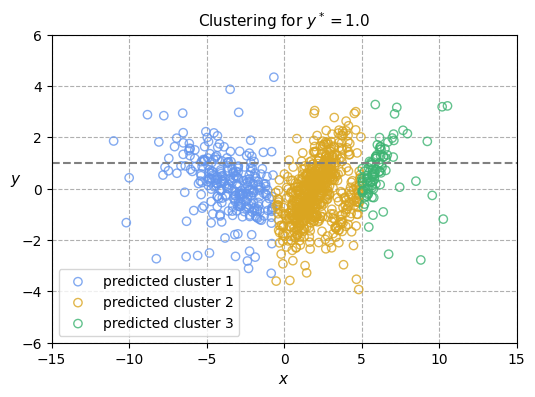

In [14]:
plt.figure(figsize=(6, 4), dpi=100)

plt.scatter(x_train[labels_pred==0], y_train[labels_pred==0], facecolors="none", edgecolors="cornflowerblue", zorder=2, alpha=0.8, label="predicted cluster 1")
plt.scatter(x_train[labels_pred==1], y_train[labels_pred==1], facecolors="none", edgecolors="goldenrod", zorder=2, alpha=0.8, label="predicted cluster 2")
plt.scatter(x_train[labels_pred==2], y_train[labels_pred==2], facecolors="none", edgecolors="mediumseagreen", zorder=2, alpha=0.8, label="predicted cluster 3")
plt.axhline(y=y_star[0], color="grey", linestyle='--')

plt.title("Clustering for $y^*=1.0$", fontsize=11)
plt.legend()
plt.xlim(-15, 15)
plt.ylim(-6, 6)
plt.xlabel("$x$", fontsize=11)
plt.ylabel("$y$", fontsize=11, rotation=0)
plt.grid(linestyle="--")
plt.show()

Obserwacja: czym bliżej wartości warunkowej $y^*=1.0$, tym większy sens ma taka klasteryzacja.